# NeuroTracker CDA Analysis

In [13]:
import numpy as np
import pandas as pd
import glob
import pickle

import mne
from mne import Epochs, pick_channels, find_events
from mne.io import read_raw_bdf

import collections
from autoreject import AutoReject

import sys
sys.path.append('/Users/nick/Documents/PhD/CLCT/InLook/NeuroTracker/')
from cda_utils import get_epochs, get_CDA, prep_report, fill_report, get_report, checksum, add_cda_report, get_CDA_perf_report
#from events import get_specific_events

import matplotlib
import matplotlib.pyplot as plt
%matplotlib qt

# 0 - General Info

In [282]:
#==================================================================
# General Variables
#==================================================================
# Organize Triggers
trigger = 2

# Triggers
# 1 - New Spheres.
# 2 - Red Spheres.
# 4 - Start Moving.
# 8 - Stop Moving.
# 16 - TBD (~4 of them... and 4 blocks.)
# 32 - TBD (juste juste avant le 1, so I guess fin de trial, I have 88 of them... 4 trials)
# 

# T2 = T1 + 5s 
# T4 = T2 + 2s
# T8 = T4 + 9s ?! (9s ?)
# T16 = T8 + ~1s
# T32 = T8 + 25s   ensuite un autre 3s plus tard.

# Beaucoup de 1 et 32.. pas clair...

# --------------------------
conds = ['1', '2', '3']
sides = ['right', 'left', 'classicmod']
perfs = ['good', 'bad']

custom_trigger = dict()
custom_trigger['1'] = 100
custom_trigger['2'] = 200
custom_trigger['3'] = 300
custom_trigger['right'] = 10
custom_trigger['left'] = 20
custom_trigger['classicmod'] = 30
custom_trigger['good'] = 1
custom_trigger['bad'] = 2

# Making Event ID Dict to make it easy and readable to access (the desired) epochs.
event_id = dict()
for cond in conds:
    for side in sides:
        for perf in perfs:
            event_id['{}/{}/{}'.format(cond, side, perf)] = custom_trigger[cond] + custom_trigger[side] + custom_trigger[perf]

#report = prep_report(conds, sides, perfs)

# CDA Channels
chan_right = ['PO8', 'PO4', 'P8', 'AF4']
chan_left = ['PO7', 'PO3', 'P7', 'AF3']

# Epoch Information
epoch_length = 20
epoch_tmin = -3
baseline_corr = (-1, -0.6)

# CDA main variable!
cda_dict = dict()
cda_dict_clean = dict()
epochs_dict = dict()

## 1. Prep Data

In [33]:
#==================================================================
# Main Loop - Loading All Files & Extract CDAs.
#==================================================================
directory_path = '/Users/nick/Documents/PhD/CAE - InLook/NeuroTracker - Sub/'

filepath = directory_path + 'F12F2.bdf'
#for filepath in glob.iglob(directory_path + '*.bdf'):
filename = filepath[filepath.rfind('/')+1:]
print('Processing: ' + filename + '...')

# 1. -- Load File --
raw = read_raw_bdf(filepath, preload=True)

# 2. -- General Preprocess --
# Keep only EEG channels and reference
raw = raw.drop_channels(ch_names=['EXG1','EXG2','EXG3','EXG6','EXG7', 'EXG8'])
raw = raw.set_eeg_reference(ref_channels=['EXG4', 'EXG5'])
raw = raw.set_channel_types({'EXG4': 'misc', 'EXG5': 'misc'})

# Set Electrodes Locations
montage = mne.channels.make_standard_montage('biosemi64')
raw.set_montage(montage)

# Resample
preproc = raw.resample(500)

# Filter
preproc = preproc.filter(.1, 50., fir_design='firwin', skip_by_annotation='edge')

# ------------------------
# 3. -- Epochs --
# ------------------------
events = find_events(preproc)

# ---------- Debug Logs ----------
frequency = collections.Counter(events[:,2])
events_frequency = dict(frequency)
print('Max Events in File...')
print("---------------------------")
for e in set(events[:,2]):
    print("{}: \t\t{}".format(e, frequency[e]))
print("---------------------------")
# ---------- Debug Logs ----------

df_behav = pd.read_csv(directory_path + filename[:filename.rfind('.')] + '.csv', sep=',')

new_events = []
nb_trials = 0
total_skipped = 0
for e in events:
    cur_cond = None
    cur_side = None
    cur_perf = None
    if e[2] == 2: # Find Start of Trial
        cur_cond = str(df_behav['NbTargets'].values[nb_trials]).lower()
        cur_side = str(df_behav['Mode'].values[nb_trials]).lower()
        cur_perf = 'good' if (int(df_behav['NbTargets'].values[nb_trials]) == int(df_behav['Results'].values[nb_trials])) else 'bad'
        if cur_cond is not None and cur_side is not None and cur_perf is not None:
            #temp_trigger = int(custom_trigger[cur_cond]) + int(custom_trigger[cur_side]) + int (custom_trigger[cur_perf])
            temp_event = [e[0], e[1], event_id['{}/{}/{}'.format(cur_cond, cur_side, cur_perf)]]
            new_events.append(temp_event) # Make a new list of events with new custom triggers.
        else:
            total_skipped = total_skipped + 1
            print('Skipping this event {}: No Cond or Side or Perf'.format(e))

        nb_trials = nb_trials + 1

        # Check Synch!
        if (nb_trials + 1) % 10 == 0:
            print('Check Synch!')

print("A total of {} trials were added and {} were skipped.".format(nb_trials, total_skipped))

epochs = Epochs(preproc, new_events, event_id=event_id, tmin=epoch_tmin, tmax=epoch_length, baseline=baseline_corr, preload=True, event_repeated='merge', on_missing='warn')
#epochs = get_epochs(preproc, specific_events, epoch_length, epoch_tmin, baseline_corr)

# ------------------------
# X. -- CLEANING! --
# TODO: Stack toutes les epochs et clean them all at once, au lieu de genre 13 à la fois...
# ------------------------
#ar = AutoReject()

#cleaned_epochs = epochs_dict[filename]
#cleaned_epochs = ar.fit_transform(epochs_dict[filename])

# ------------------------
# 4. - Report & Checksum -
# ------------------------
#report = fill_report(report, filename, specific_events)
#report_clean = fill_report(report, filename, epochs_dict_clean)
#report.at[filename, 'checksum'] = checksum(specific_events, epochs_dict[filename])

# ------------------------
# 5. -- CDA --
# ------------------------
#cda_dict[filename] = get_CDA(epochs_dict[filename], conds, sides, perfs, chan_right, chan_left)
#cda_dict_clean[filename] = get_CDA(epochs_dict_clean, conds, sides, ['good'], chan_right, chan_left)

# Add time points to CDA for later use.
#times = 

# Print report
#subreport = get_report(report, ['1','2', '4'], ['left','right'], ['good', 'bad'], [])
#report

Processing: F12F2.bdf...
Extracting EDF parameters from /Users/nick/Documents/PhD/CAE - InLook/NeuroTracker - Sub/F12F2.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 5986303  =      0.000 ...  2923.000 secs...
EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Trigger channel has a non-zero initial value of 65536 (consider using initial_event=True to detect this event)
Removing orphaned offset at the beginning of the file.
516 events found
Event IDs: [ 1  2  4  8 16 32]
Trigger channel has a non-zero initial value of 65536 (consider using initial_event=True to detect this event)
Removing orphaned offset at the beginning of the file.
516 events found
Event IDs: [ 1  2  4  8 16 32]
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain des

/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_9709/2236780832.py:74: RuntimeWarning: No matching events found for 1/right/bad (event id 112)
  epochs = Epochs(preproc, new_events, event_id=event_id, tmin=epoch_tmin, tmax=epoch_length, baseline=baseline_corr, preload=True, event_repeated='merge', on_missing='warn')


0 bad epochs dropped


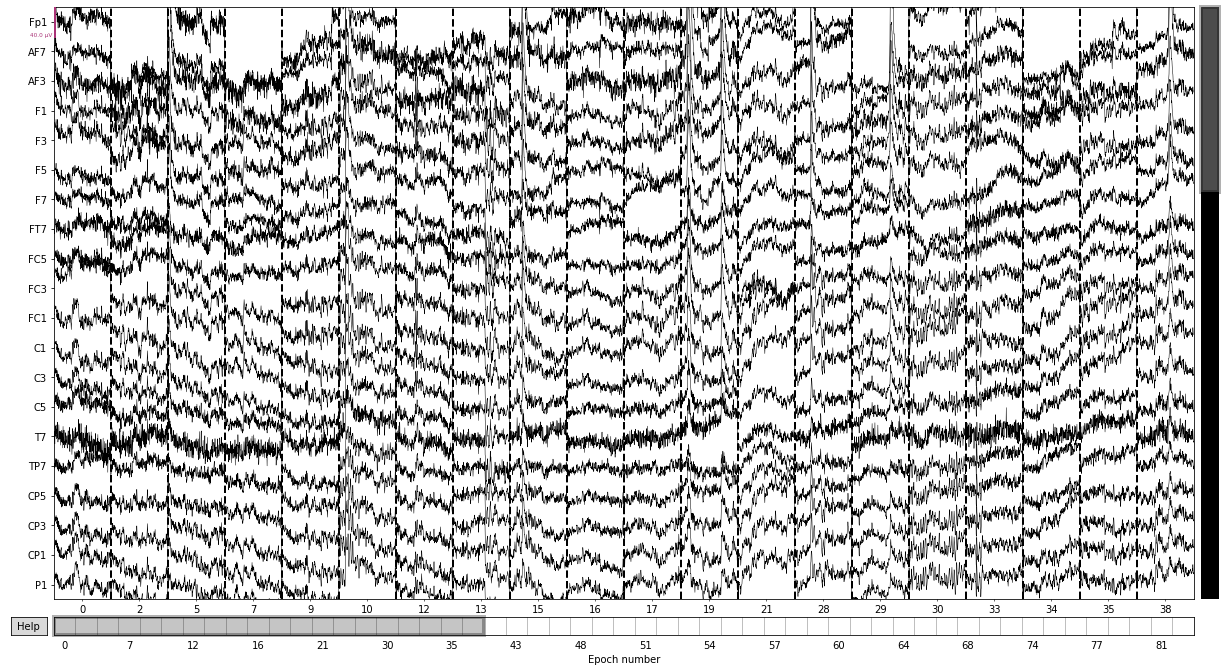

In [45]:
%matplotlib inline
x = epochs['good'].copy().crop(tmin=-0.2, tmax=2).plot(block=True)

    Using multitaper spectrum estimation with 7 DPSS windows


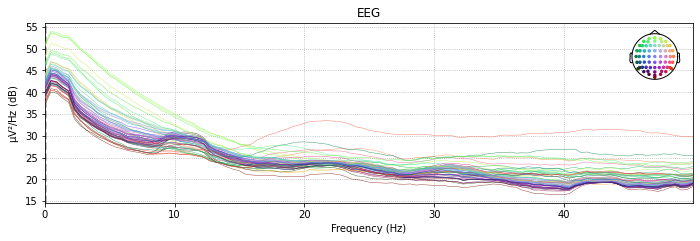

In [46]:
%matplotlib inline
x = epochs['good'].copy().crop(tmin=-0.2, tmax=2).plot_psd(fmax=50)

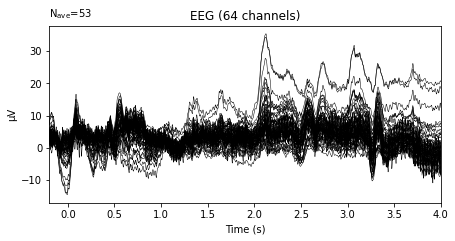

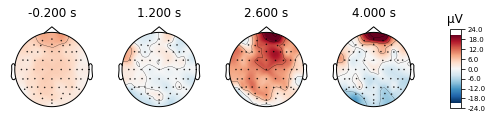

No projector specified for this dataset. Please consider the method self.add_proj.


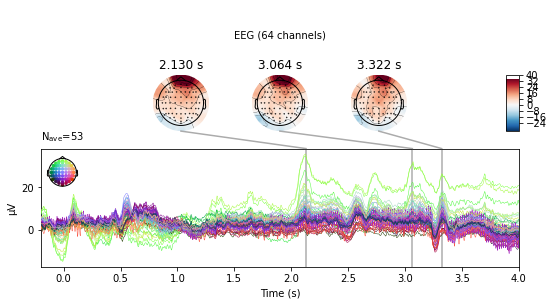

In [51]:
evoked_good = epochs['good'].copy().crop(tmin=-0.2, tmax=4).average()
x = evoked_good.plot()
x = evoked_good.plot_topomap()
x = evoked_good.plot_joint()

EEG channel type selected for re-referencing
Added the following bipolar channels:
PO8-PO7, PO4-PO3, P8-P7
EEG channel type selected for re-referencing
Added the following bipolar channels:
PO8-PO7, PO4-PO3, P8-P7


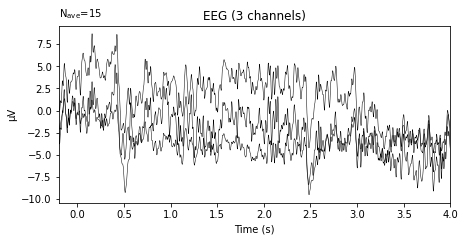

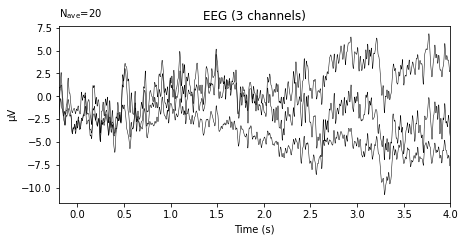

In [63]:
evoked_left_good = epochs['left/good'].copy().crop(tmin=-0.2, tmax=4).average()
evoked_right_good = epochs['right/good'].copy().crop(tmin=-0.2, tmax=4).average()

evoked_lgood_bipolar = mne.set_bipolar_reference(evoked_left_good, anode=chan_right, cathode=chan_left)
evoked_rgood_bipolar = mne.set_bipolar_reference(evoked_right_good, anode=chan_right, cathode=chan_left)

x = evoked_lgood_bipolar.plot(picks=['P8-P7', 'PO8-PO7', 'PO4-PO3'])
x = evoked_rgood_bipolar.plot(picks=['P8-P7', 'PO8-PO7', 'PO4-PO3'])

In [72]:
from mne.time_frequency import tfr_morlet

epochs_good = epochs['good'].copy().crop(tmin=-0.2, tmax=4)
epochs_good = mne.set_bipolar_reference(epochs_good, anode=chan_right, cathode=chan_left)
epochs_good.pick_channels(['P8-P7', 'PO8-PO7', 'PO4-PO3'])

freqs = np.logspace(*np.log10([6, 35]), num=8)
n_cycles = freqs / 2.  # different number of cycle per frequency
power, itc = tfr_morlet(epochs_good, freqs=freqs, n_cycles=n_cycles, use_fft=True,
                        return_itc=True, decim=3, n_jobs=1)

EEG channel type selected for re-referencing
Not setting metadata
Not setting metadata
53 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Added the following bipolar channels:
PO8-PO7, PO4-PO3, P8-P7


Applying baseline correction (mode: mean)


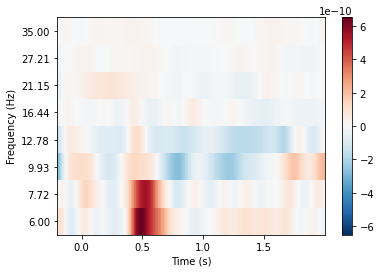

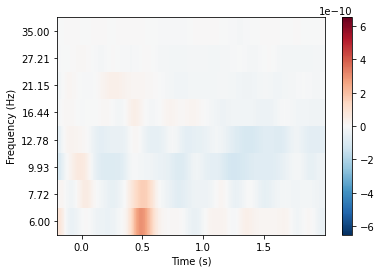

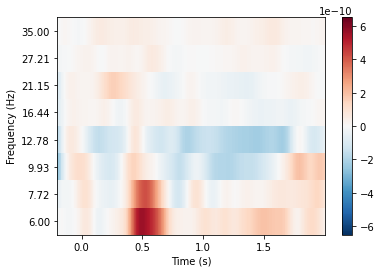

[<Figure size 432x288 with 2 Axes>,
 <Figure size 432x288 with 2 Axes>,
 <Figure size 432x288 with 2 Axes>]

In [73]:
power.plot(baseline=(-0.2, 0), mode='mean', tmin=-.2, tmax=2,)

No baseline correction applied


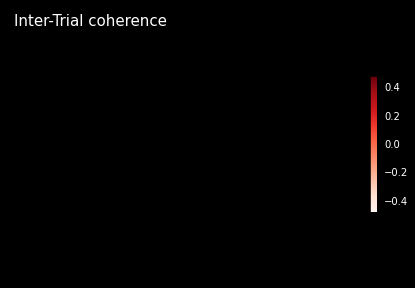

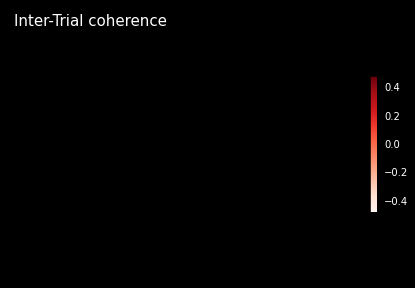

In [75]:
itc.plot_topo(title='Inter-Trial coherence', cmap='Reds')

No baseline correction applied


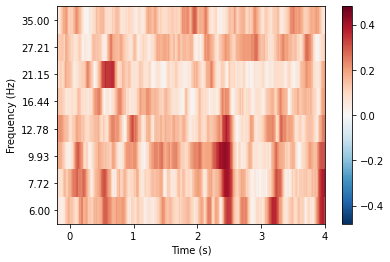

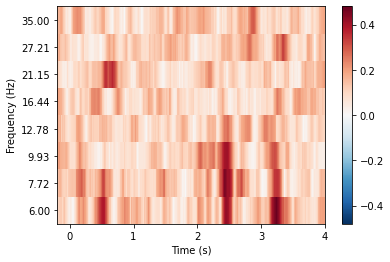

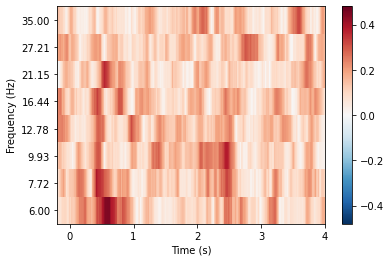

[<Figure size 432x288 with 2 Axes>,
 <Figure size 432x288 with 2 Axes>,
 <Figure size 432x288 with 2 Axes>]

In [77]:
itc.plot()

# Machine Learning - CDA

EEG channel type selected for re-referencing
Added the following bipolar channels:
PO8-PO7, PO4-PO3, P8-P7
EEG channel type selected for re-referencing
Added the following bipolar channels:
PO8-PO7, PO4-PO3, P8-P7


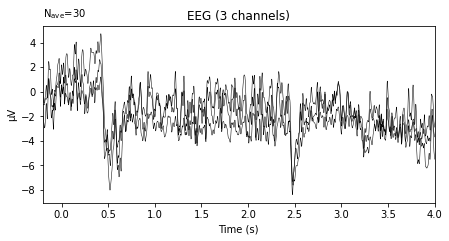

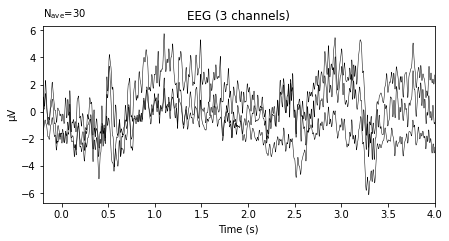

In [78]:
evoked_left = epochs['left'].copy().crop(tmin=-0.2, tmax=4).average()
evoked_right = epochs['right'].copy().crop(tmin=-0.2, tmax=4).average()

evoked_left_bipolar = mne.set_bipolar_reference(evoked_left, anode=chan_right, cathode=chan_left).pick_channels(['P8-P7', 'PO8-PO7', 'PO4-PO3'])
evoked_right_bipolar = mne.set_bipolar_reference(evoked_right, anode=chan_right, cathode=chan_left).pick_channels(['P8-P7', 'PO8-PO7', 'PO4-PO3'])

x = evoked_left_bipolar.plot()
x = evoked_right_bipolar.plot()

In [149]:

epochs_left = epochs['left'].copy().crop(tmin=0, tmax=1.0)
epochs_right = epochs['right'].copy().crop(tmin=0, tmax=1.0)

epochs_left_bipolar = mne.set_bipolar_reference(epochs_left, anode=chan_right, cathode=chan_left).pick_channels(['PO8-PO7'])#['P8-P7', 'PO8-PO7', 'PO4-PO3', 'AF4-AF3'])
epochs_right_bipolar = mne.set_bipolar_reference(epochs_right, anode=chan_right, cathode=chan_left).pick_channels(['PO8-PO7'])#['P8-P7', 'PO8-PO7', 'PO4-PO3', 'AF4-AF3'])

nb_trials = len(epochs_left_bipolar) + len(epochs_right_bipolar)

EEG channel type selected for re-referencing
Not setting metadata
Not setting metadata
30 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Added the following bipolar channels:
PO8-PO7, PO4-PO3, P8-P7, AF4-AF3
EEG channel type selected for re-referencing
Not setting metadata
Not setting metadata
30 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Added the following bipolar channels:
PO8-PO7, PO4-PO3, P8-P7, AF4-AF3


In [150]:
# Prepare X and y data for ML

# Left = 0, Right = 1
y = np.array([0 for i in range(len(epochs_left_bipolar))] + [1 for i in range(len(epochs_right_bipolar))])

data = np.vstack([epochs_left_bipolar.get_data(), epochs_right_bipolar.get_data()])
X = data.reshape(nb_trials, -1)
X.shape

(60, 501)

## From Scikit-Learn

In [151]:
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

clf = make_pipeline(StandardScaler(), 
                    LogisticRegression())

n_splits = 5
scoring = 'roc_auc'
cv = StratifiedKFold(n_splits=n_splits)
scores = cross_val_score(clf, X=X, y=y, cv=cv, scoring=scoring)

roc_auc_mean = round(np.mean(scores), 3)
roc_auc_std = round(np.std(scores), 3)

print(f'CV scores: {scores}')
print(f'Mean ROC AUC = {roc_auc_mean:.3f} (SD = {roc_auc_std:.3f})')

CV scores: [1.         0.91666667 0.94444444 1.         1.        ]
Mean ROC AUC = 0.972 (SD = 0.035)


Text(0.5, 1.0, 'Cross-Validation Score')

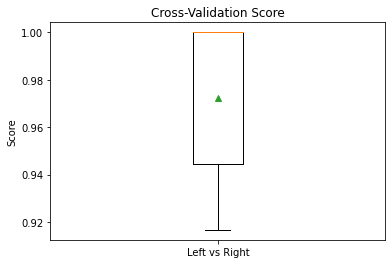

In [152]:
fig, ax = plt.subplots()
ax.boxplot(scores, showmeans=True, whis=(0,100), labels=['Left vs Right'])
ax.set_ylabel('Score')
ax.set_title('Cross-Validation Score')

# From MNE ML

In [269]:
#==================================================================
# Main Loop - Loading All Files & Extract CDAs.
#==================================================================
directory_path = '/Users/nick/Documents/PhD/CAE - InLook/NeuroTracker - Sub/'

filepath = directory_path + 'F12F2.bdf'
#for filepath in glob.iglob(directory_path + '*.bdf'):
filename = filepath[filepath.rfind('/')+1:]
print('Processing: ' + filename + '...')

# 1. -- Load File --
raw = read_raw_bdf(filepath, preload=True)

# 2. -- General Preprocess --
# Keep only EEG channels and reference
raw = raw.drop_channels(ch_names=['EXG1','EXG2','EXG3','EXG6','EXG7', 'EXG8'])
raw = raw.set_eeg_reference(ref_channels=['EXG4', 'EXG5'])
raw = raw.set_channel_types({'EXG4': 'misc', 'EXG5': 'misc'})

# Set Electrodes Locations
montage = mne.channels.make_standard_montage('biosemi64')
raw.set_montage(montage)
raw = mne.set_bipolar_reference(raw, anode=chan_right, cathode=chan_left)

# Resample
preproc = raw.resample(500)

# Filter
preproc = preproc.filter(.1, 50., fir_design='firwin', skip_by_annotation='edge')

# ------------------------
# 3. -- Epochs --
# ------------------------
events = find_events(preproc)

preproc = preproc.pick_channels(['P8-P7', 'PO8-PO7', 'PO4-PO3', 'AF4-AF3'])
#preproc = preproc.pick_channels(['AF4-AF3'])

# ---------- Debug Logs ----------
frequency = collections.Counter(events[:,2])
events_frequency = dict(frequency)
print('Max Events in File...')
print("---------------------------")
for e in set(events[:,2]):
    print("{}: \t\t{}".format(e, frequency[e]))
print("---------------------------")
# ---------- Debug Logs ----------

df_behav = pd.read_csv(directory_path + filename[:filename.rfind('.')] + '.csv', sep=',')

new_events = []
nb_trials = 0
total_skipped = 0
for e in events:
    cur_cond = None
    cur_side = None
    cur_perf = None
    if e[2] == 2: # Find Start of Trial
        cur_cond = str(df_behav['NbTargets'].values[nb_trials]).lower()
        cur_side = str(df_behav['Mode'].values[nb_trials]).lower()
        cur_perf = 'good' if (int(df_behav['NbTargets'].values[nb_trials]) == int(df_behav['Results'].values[nb_trials])) else 'bad'
        if cur_cond is not None and cur_side is not None and cur_perf is not None:
            #temp_trigger = int(custom_trigger[cur_cond]) + int(custom_trigger[cur_side]) + int (custom_trigger[cur_perf])
            temp_event = [e[0], e[1], event_id['{}/{}/{}'.format(cur_cond, cur_side, cur_perf)]]
            new_events.append(temp_event) # Make a new list of events with new custom triggers.
        else:
            total_skipped = total_skipped + 1
            print('Skipping this event {}: No Cond or Side or Perf'.format(e))

        nb_trials = nb_trials + 1

        # Check Synch!
        if (nb_trials + 1) % 10 == 0:
            print('Check Synch!')

print("A total of {} trials were added and {} were skipped.".format(nb_trials, total_skipped))

epochs = Epochs(preproc, new_events, event_id=event_id, tmin=epoch_tmin, tmax=epoch_length, baseline=baseline_corr, preload=True, event_repeated='merge', on_missing='warn')
#epochs = get_epochs(preproc, specific_events, epoch_length, epoch_tmin, baseline_corr)

Processing: F12F2.bdf...
Extracting EDF parameters from /Users/nick/Documents/PhD/CAE - InLook/NeuroTracker - Sub/F12F2.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 5986303  =      0.000 ...  2923.000 secs...
EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
EEG channel type selected for re-referencing
Creating RawArray with float64 data, n_channels=4, n_times=5986304
    Range : 0 ... 5986303 =      0.000 ...  2923.000 secs
Ready.
Added the following bipolar channels:
PO8-PO7, PO4-PO3, P8-P7, AF4-AF3
Trigger channel has a non-zero initial value of 65536 (consider using initial_event=True to detect this event)
Removing orphaned offset at the beginning of the file.
516 events found
Event IDs: [ 1  2  4  8 16 32]
Trigger channel has a non-zero initial value of 65536 (consider using initial_event=True to detect this event)
Removing orphaned offset at the beginning of the file.
516 events found
Even

/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_9709/3356278492.py:78: RuntimeWarning: No matching events found for 1/right/bad (event id 112)
  epochs = Epochs(preproc, new_events, event_id=event_id, tmin=epoch_tmin, tmax=epoch_length, baseline=baseline_corr, preload=True, event_repeated='merge', on_missing='warn')


In [ ]:
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from mne.decoding import Scaler, Vectorizer, cross_val_multiscore, SlidingEstimator

epochs_lf = epochs[['left','right']] # To avoid the Classic Mod

x = epochs_lf['left'].average().plot()
x = epochs_lf['right'].average().plot()

X = epochs_lf.get_data()
y = [0 if e[0] in epochs_lf['left'].events[:,0] else 1 for i,e in enumerate(epochs_lf.events)]

#clf = make_pipeline(Scaler(epochs_lf.info), Vectorizer(), LogisticRegression())
clf = make_pipeline(StandardScaler(), LogisticRegression())

scoring = 'roc_auc'
time_decoder = SlidingEstimator(clf, scoring=scoring, n_jobs=1, verbose=True)

n_splits = 5
scores = cross_val_multiscore(time_decoder, X=X, y=y, cv=n_splits)

mean_scores = np.mean(scores, axis=0)
mean_scores

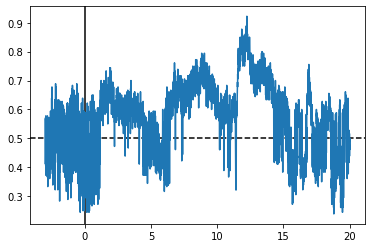

In [207]:
fix, ax = plt.subplots()

ax.axhline(0.5, color='k', linestyle='--', label='chance')
ax.axvline(0, color='k', linestyle='-')
ax.plot(epochs.times, mean_scores, label='score')

## ML: G vs B

In [219]:
#==================================================================
# Main Loop - Loading All Files & Extract CDAs.
#==================================================================
directory_path = '/Users/nick/Documents/PhD/CAE - InLook/NeuroTracker - Sub/'

filepath = directory_path + 'F12F2.bdf'
#for filepath in glob.iglob(directory_path + '*.bdf'):
filename = filepath[filepath.rfind('/')+1:]
print('Processing: ' + filename + '...')

# 1. -- Load File --
raw = read_raw_bdf(filepath, preload=True)

# 2. -- General Preprocess --
# Keep only EEG channels and reference
raw = raw.drop_channels(ch_names=['EXG1','EXG2','EXG3','EXG6','EXG7', 'EXG8'])
raw = raw.set_eeg_reference(ref_channels=['EXG4', 'EXG5'])
raw = raw.set_channel_types({'EXG4': 'misc', 'EXG5': 'misc'})

# Set Electrodes Locations
montage = mne.channels.make_standard_montage('biosemi64')
raw.set_montage(montage)
raw = mne.set_bipolar_reference(raw, anode=chan_right, cathode=chan_left)

# Resample
preproc = raw.resample(500)

# Filter
preproc = preproc.filter(.1, 50., fir_design='firwin', skip_by_annotation='edge')

# ------------------------
# 3. -- Epochs --
# ------------------------
events = find_events(preproc)

#preproc = preproc.pick_channels(['P8-P7', 'PO8-PO7', 'PO4-PO3', 'AF4-AF3'])
preproc = preproc.pick_channels(['P8-P7'])

# ---------- Debug Logs ----------
frequency = collections.Counter(events[:,2])
events_frequency = dict(frequency)
print('Max Events in File...')
print("---------------------------")
for e in set(events[:,2]):
    print("{}: \t\t{}".format(e, frequency[e]))
print("---------------------------")
# ---------- Debug Logs ----------

df_behav = pd.read_csv(directory_path + filename[:filename.rfind('.')] + '.csv', sep=',')

new_events = []
nb_trials = 0
total_skipped = 0
for e in events:
    cur_cond = None
    cur_side = None
    cur_perf = None
    if e[2] == 2: # Find Start of Trial
        cur_cond = str(df_behav['NbTargets'].values[nb_trials]).lower()
        cur_side = str(df_behav['Mode'].values[nb_trials]).lower()
        cur_perf = 'good' if (int(df_behav['NbTargets'].values[nb_trials]) == int(df_behav['Results'].values[nb_trials])) else 'bad'
        if cur_cond is not None and cur_side is not None and cur_perf is not None:
            #temp_trigger = int(custom_trigger[cur_cond]) + int(custom_trigger[cur_side]) + int (custom_trigger[cur_perf])
            temp_event = [e[0], e[1], event_id['{}/{}/{}'.format(cur_cond, cur_side, cur_perf)]]
            new_events.append(temp_event) # Make a new list of events with new custom triggers.
        else:
            total_skipped = total_skipped + 1
            print('Skipping this event {}: No Cond or Side or Perf'.format(e))

        nb_trials = nb_trials + 1

        # Check Synch!
        if (nb_trials + 1) % 10 == 0:
            print('Check Synch!')

print("A total of {} trials were added and {} were skipped.".format(nb_trials, total_skipped))

epochs = Epochs(preproc, new_events, event_id=event_id, tmin=epoch_tmin, tmax=epoch_length, baseline=baseline_corr, preload=True, event_repeated='merge', on_missing='warn')
#epochs = get_epochs(preproc, specific_events, epoch_length, epoch_tmin, baseline_corr)

Processing: F12F2.bdf...
Extracting EDF parameters from /Users/nick/Documents/PhD/CAE - InLook/NeuroTracker - Sub/F12F2.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 5986303  =      0.000 ...  2923.000 secs...
EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
EEG channel type selected for re-referencing
Creating RawArray with float64 data, n_channels=4, n_times=5986304
    Range : 0 ... 5986303 =      0.000 ...  2923.000 secs
Ready.
Added the following bipolar channels:
PO8-PO7, PO4-PO3, P8-P7, AF4-AF3
Trigger channel has a non-zero initial value of 65536 (consider using initial_event=True to detect this event)
Removing orphaned offset at the beginning of the file.
516 events found
Event IDs: [ 1  2  4  8 16 32]
Trigger channel has a non-zero initial value of 65536 (consider using initial_event=True to detect this event)
Removing orphaned offset at the beginning of the file.
516 events found
Even

/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_9709/1235072650.py:78: RuntimeWarning: No matching events found for 1/right/bad (event id 112)
  epochs = Epochs(preproc, new_events, event_id=event_id, tmin=epoch_tmin, tmax=epoch_length, baseline=baseline_corr, preload=True, event_repeated='merge', on_missing='warn')


Need more than one channel to make topography for eeg. Disabling interactivity.


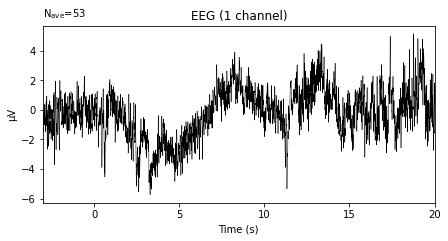

Need more than one channel to make topography for eeg. Disabling interactivity.


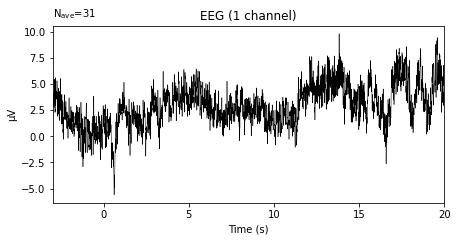

  0%|          | Fitting SlidingEstimator : 0/11501 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/11501 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/11501 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/11501 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/11501 [00:00<?,       ?it/s]

array([0.63030303, 0.62311688, 0.60679654, ..., 0.62727273, 0.63558442,
       0.63796537])

In [220]:
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from mne.decoding import Scaler, Vectorizer, cross_val_multiscore, SlidingEstimator

epochs_lf = epochs[['good','bad']]

x = epochs_lf['good'].average().plot()
x = epochs_lf['bad'].average().plot()

X = epochs_lf.get_data()
y = [0 if e[0] in epochs_lf['bad'].events[:,0] else 1 for i,e in enumerate(epochs_lf.events)]

#clf = make_pipeline(Scaler(epochs_lf.info), Vectorizer(), LogisticRegression())
clf = make_pipeline(StandardScaler(), LogisticRegression())

scoring = 'roc_auc'
time_decoder = SlidingEstimator(clf, scoring=scoring, n_jobs=1, verbose=True)

n_splits = 5
scores = cross_val_multiscore(time_decoder, X=X, y=y, cv=n_splits)

mean_scores = np.mean(scores, axis=0)
mean_scores

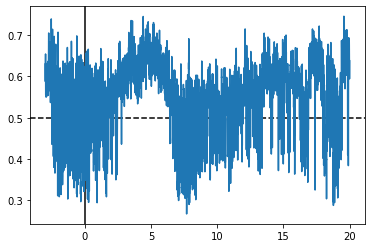

In [221]:
fix, ax = plt.subplots()

ax.axhline(0.5, color='k', linestyle='--', label='chance')
ax.axvline(0, color='k', linestyle='-')
ax.plot(epochs.times, mean_scores, label='score')

## ML: 1 vs 3

In [222]:
#==================================================================
# Main Loop - Loading All Files & Extract CDAs.
#==================================================================
directory_path = '/Users/nick/Documents/PhD/CAE - InLook/NeuroTracker - Sub/'

filepath = directory_path + 'F12F2.bdf'
#for filepath in glob.iglob(directory_path + '*.bdf'):
filename = filepath[filepath.rfind('/')+1:]
print('Processing: ' + filename + '...')

# 1. -- Load File --
raw = read_raw_bdf(filepath, preload=True)

# 2. -- General Preprocess --
# Keep only EEG channels and reference
raw = raw.drop_channels(ch_names=['EXG1','EXG2','EXG3','EXG6','EXG7', 'EXG8'])
raw = raw.set_eeg_reference(ref_channels=['EXG4', 'EXG5'])
raw = raw.set_channel_types({'EXG4': 'misc', 'EXG5': 'misc'})

# Set Electrodes Locations
montage = mne.channels.make_standard_montage('biosemi64')
raw.set_montage(montage)
raw = mne.set_bipolar_reference(raw, anode=chan_right, cathode=chan_left)

# Resample
preproc = raw.resample(500)

# Filter
preproc = preproc.filter(.1, 50., fir_design='firwin', skip_by_annotation='edge')

# ------------------------
# 3. -- Epochs --
# ------------------------
events = find_events(preproc)

#preproc = preproc.pick_channels(['P8-P7', 'PO8-PO7', 'PO4-PO3', 'AF4-AF3'])
preproc = preproc.pick_channels(['PO8-PO7'])

# ---------- Debug Logs ----------
frequency = collections.Counter(events[:,2])
events_frequency = dict(frequency)
print('Max Events in File...')
print("---------------------------")
for e in set(events[:,2]):
    print("{}: \t\t{}".format(e, frequency[e]))
print("---------------------------")
# ---------- Debug Logs ----------

df_behav = pd.read_csv(directory_path + filename[:filename.rfind('.')] + '.csv', sep=',')

new_events = []
nb_trials = 0
total_skipped = 0
for e in events:
    cur_cond = None
    cur_side = None
    cur_perf = None
    if e[2] == 2: # Find Start of Trial
        cur_cond = str(df_behav['NbTargets'].values[nb_trials]).lower()
        cur_side = str(df_behav['Mode'].values[nb_trials]).lower()
        cur_perf = 'good' if (int(df_behav['NbTargets'].values[nb_trials]) == int(df_behav['Results'].values[nb_trials])) else 'bad'
        if cur_cond is not None and cur_side is not None and cur_perf is not None:
            #temp_trigger = int(custom_trigger[cur_cond]) + int(custom_trigger[cur_side]) + int (custom_trigger[cur_perf])
            temp_event = [e[0], e[1], event_id['{}/{}/{}'.format(cur_cond, cur_side, cur_perf)]]
            new_events.append(temp_event) # Make a new list of events with new custom triggers.
        else:
            total_skipped = total_skipped + 1
            print('Skipping this event {}: No Cond or Side or Perf'.format(e))

        nb_trials = nb_trials + 1

        # Check Synch!
        if (nb_trials + 1) % 10 == 0:
            print('Check Synch!')

print("A total of {} trials were added and {} were skipped.".format(nb_trials, total_skipped))

epochs = Epochs(preproc, new_events, event_id=event_id, tmin=epoch_tmin, tmax=epoch_length, baseline=baseline_corr, preload=True, event_repeated='merge', on_missing='warn')
#epochs = get_epochs(preproc, specific_events, epoch_length, epoch_tmin, baseline_corr)

Processing: F12F2.bdf...
Extracting EDF parameters from /Users/nick/Documents/PhD/CAE - InLook/NeuroTracker - Sub/F12F2.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 5986303  =      0.000 ...  2923.000 secs...
EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
EEG channel type selected for re-referencing
Creating RawArray with float64 data, n_channels=4, n_times=5986304
    Range : 0 ... 5986303 =      0.000 ...  2923.000 secs
Ready.
Added the following bipolar channels:
PO8-PO7, PO4-PO3, P8-P7, AF4-AF3
Trigger channel has a non-zero initial value of 65536 (consider using initial_event=True to detect this event)
Removing orphaned offset at the beginning of the file.
516 events found
Event IDs: [ 1  2  4  8 16 32]
Trigger channel has a non-zero initial value of 65536 (consider using initial_event=True to detect this event)
Removing orphaned offset at the beginning of the file.
516 events found
Even

/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_9709/1278079449.py:78: RuntimeWarning: No matching events found for 1/right/bad (event id 112)
  epochs = Epochs(preproc, new_events, event_id=event_id, tmin=epoch_tmin, tmax=epoch_length, baseline=baseline_corr, preload=True, event_repeated='merge', on_missing='warn')


Need more than one channel to make topography for eeg. Disabling interactivity.


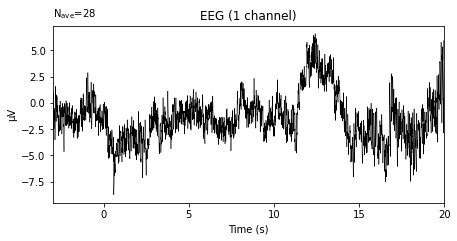

Need more than one channel to make topography for eeg. Disabling interactivity.


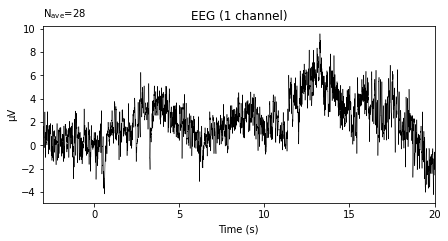

  0%|          | Fitting SlidingEstimator : 0/11501 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/11501 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/11501 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/11501 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/11501 [00:00<?,       ?it/s]

array([0.44      , 0.43444444, 0.42333333, ..., 0.63666667, 0.62444444,
       0.63      ])

In [223]:
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from mne.decoding import Scaler, Vectorizer, cross_val_multiscore, SlidingEstimator

epochs_13 = epochs[['1','3']]

x = epochs_13['1'].average().plot()
x = epochs_13['3'].average().plot()

X = epochs_13.get_data()
y = [0 if e[0] in epochs_13['1'].events[:,0] else 1 for i,e in enumerate(epochs_13.events)]

#clf = make_pipeline(Scaler(epochs_lf.info), Vectorizer(), LogisticRegression())
clf = make_pipeline(StandardScaler(), LogisticRegression())

scoring = 'roc_auc'
time_decoder = SlidingEstimator(clf, scoring=scoring, n_jobs=1, verbose=True)

n_splits = 5
scores = cross_val_multiscore(time_decoder, X=X, y=y, cv=n_splits)

mean_scores = np.mean(scores, axis=0)
mean_scores

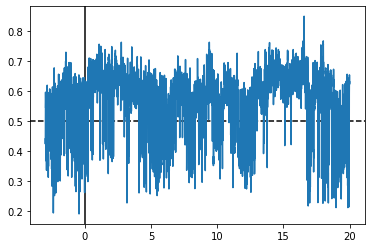

In [224]:
fix, ax = plt.subplots()

ax.axhline(0.5, color='k', linestyle='--', label='chance')
ax.axvline(0, color='k', linestyle='-')
ax.plot(epochs.times, mean_scores, label='score')

Need more than one channel to make topography for eeg. Disabling interactivity.


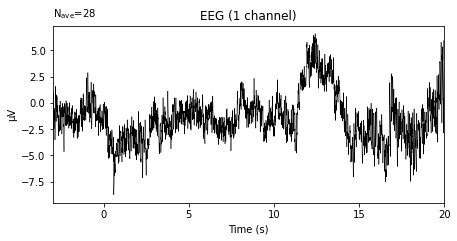

Need more than one channel to make topography for eeg. Disabling interactivity.


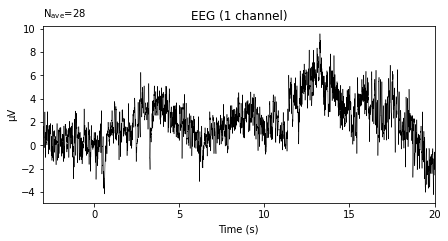

  0%|          | Fitting SlidingEstimator : 0/11501 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/11501 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/11501 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/11501 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/11501 [00:00<?,       ?it/s]

array([0.44      , 0.43444444, 0.42333333, ..., 0.63666667, 0.62444444,
       0.63      ])

In [226]:
from sklearn import svm
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from mne.decoding import Scaler, Vectorizer, cross_val_multiscore, SlidingEstimator

epochs_13 = epochs[['1','3']]

x = epochs_13['1'].average().plot()
x = epochs_13['3'].average().plot()

X = epochs_13.get_data()
y = [0 if e[0] in epochs_13['1'].events[:,0] else 1 for i,e in enumerate(epochs_13.events)]

#clf = make_pipeline(Scaler(epochs_lf.info), Vectorizer(), LogisticRegression())
#clf = make_pipeline(StandardScaler(), LogisticRegression())
clf = make_pipeline(svm.SVC(kernel='linear'))

scoring = 'roc_auc'
time_decoder = SlidingEstimator(clf, scoring=scoring, n_jobs=1, verbose=True)

n_splits = 5
scores = cross_val_multiscore(time_decoder, X=X, y=y, cv=n_splits)

mean_scores = np.mean(scores, axis=0)
mean_scores

# Cleaning Data for TF Analysi

In [264]:
# Epoch Information
epoch_length = 2
epoch_tmin = -1
baseline_corr = (-0.5, 0.0)

#==================================================================
# Main Loop - Loading All Files & Extract CDAs.
#==================================================================
directory_path = '/Users/nick/Documents/PhD/CAE - InLook/NeuroTracker - Sub/'

filepath = directory_path + 'F12F2.bdf'
#for filepath in glob.iglob(directory_path + '*.bdf'):
filename = filepath[filepath.rfind('/')+1:]
print('Processing: ' + filename + '...')

# 1. -- Load File --
raw = read_raw_bdf(filepath, preload=True)

# 2. -- General Preprocess --
# Keep only EEG channels and reference
raw = raw.drop_channels(ch_names=['EXG1','EXG2','EXG3','EXG6','EXG7', 'EXG8'])
raw = raw.set_eeg_reference(ref_channels=['EXG4', 'EXG5'])
raw = raw.set_channel_types({'EXG4': 'misc', 'EXG5': 'misc'})

# Set Electrodes Locations
montage = mne.channels.make_standard_montage('biosemi64')
raw.set_montage(montage)
#raw = mne.set_bipolar_reference(raw, anode=chan_right, cathode=chan_left)

# Resample
preproc = raw.resample(500)

# Filter
preproc = preproc.filter(.1, 50., fir_design='firwin', skip_by_annotation='edge')

# ------------------------
# 3. -- Epochs --
# ------------------------
events = find_events(preproc)

#preproc = preproc.pick_channels(['P8-P7', 'PO8-PO7', 'PO4-PO3', 'AF4-AF3'])
#preproc = preproc.pick_channels(['P8-P7', 'PO8-PO7', 'PO4-PO3', 'AF4-AF3'])

# ---------- Debug Logs ----------
frequency = collections.Counter(events[:,2])
events_frequency = dict(frequency)
print('Max Events in File...')
print("---------------------------")
for e in set(events[:,2]):
    print("{}: \t\t{}".format(e, frequency[e]))
print("---------------------------")
# ---------- Debug Logs ----------

df_behav = pd.read_csv(directory_path + filename[:filename.rfind('.')] + '.csv', sep=',')

new_events = []
nb_trials = 0
total_skipped = 0
for e in events:
    cur_cond = None
    cur_side = None
    cur_perf = None
    if e[2] == 2: # Find Start of Trial
        cur_cond = str(df_behav['NbTargets'].values[nb_trials]).lower()
        cur_side = str(df_behav['Mode'].values[nb_trials]).lower()
        cur_perf = 'good' if (int(df_behav['NbTargets'].values[nb_trials]) == int(df_behav['Results'].values[nb_trials])) else 'bad'
        if cur_cond is not None and cur_side is not None and cur_perf is not None:
            #temp_trigger = int(custom_trigger[cur_cond]) + int(custom_trigger[cur_side]) + int (custom_trigger[cur_perf])
            temp_event = [e[0], e[1], event_id['{}/{}/{}'.format(cur_cond, cur_side, cur_perf)]]
            new_events.append(temp_event) # Make a new list of events with new custom triggers.
        else:
            total_skipped = total_skipped + 1
            print('Skipping this event {}: No Cond or Side or Perf'.format(e))

        nb_trials = nb_trials + 1

        # Check Synch!
        if (nb_trials + 1) % 10 == 0:
            print('Check Synch!')

print("A total of {} trials were added and {} were skipped.".format(nb_trials, total_skipped))

epochs = Epochs(preproc, new_events, event_id=event_id, tmin=epoch_tmin, tmax=epoch_length, baseline=baseline_corr, preload=True, event_repeated='merge', on_missing='warn')
#epochs = get_epochs(preproc, specific_events, epoch_length, epoch_tmin, baseline_corr)

ar = AutoReject()
epochs_clean = ar.fit_transform(epochs) 


Processing: F12F2.bdf...
Extracting EDF parameters from /Users/nick/Documents/PhD/CAE - InLook/NeuroTracker - Sub/F12F2.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 5986303  =      0.000 ...  2923.000 secs...
EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Trigger channel has a non-zero initial value of 65536 (consider using initial_event=True to detect this event)
Removing orphaned offset at the beginning of the file.
516 events found
Event IDs: [ 1  2  4  8 16 32]
Trigger channel has a non-zero initial value of 65536 (consider using initial_event=True to detect this event)
Removing orphaned offset at the beginning of the file.
516 events found
Event IDs: [ 1  2  4  8 16 32]
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain des

/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_9709/1393203148.py:83: RuntimeWarning: No matching events found for 1/right/bad (event id 112)
  epochs = Epochs(preproc, new_events, event_id=event_id, tmin=epoch_tmin, tmax=epoch_length, baseline=baseline_corr, preload=True, event_repeated='merge', on_missing='warn')


  0%|          | Creating augmented epochs : 0/64 [00:00<?,       ?it/s]

  0%|          | Computing thresholds ... : 0/64 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/84 [00:00<?,       ?it/s]

  0%|          | n_interp : 0/3 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/84 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/84 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]

  0%|          | Repairing epochs : 0/84 [00:00<?,       ?it/s]

  0%|          | Fold : 0/10 [00:00<?,       ?it/s]





Estimated consensus=0.30 and n_interpolate=1


  0%|          | Repairing epochs : 0/84 [00:00<?,       ?it/s]

Dropped 36 epochs: 2, 5, 6, 7, 10, 13, 15, 18, 19, 20, 28, 29, 32, 34, 37, 39, 40, 41, 47, 49, 52, 53, 62, 65, 66, 68, 70, 71, 72, 74, 76, 77, 78, 81, 82, 83


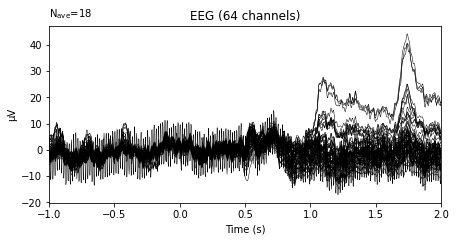

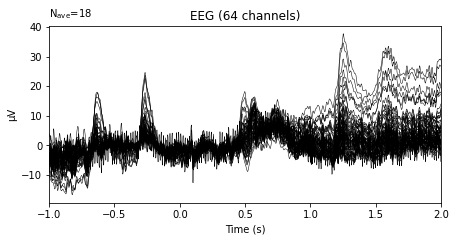

In [265]:
x = epochs_clean['left'].average().plot()
x = epochs_clean['right'].average().plot()

Applying baseline correction (mode: mean)


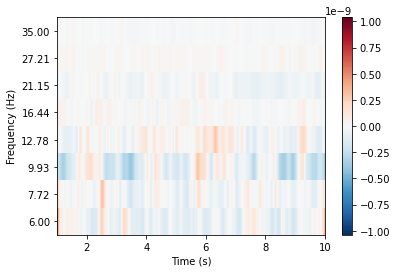

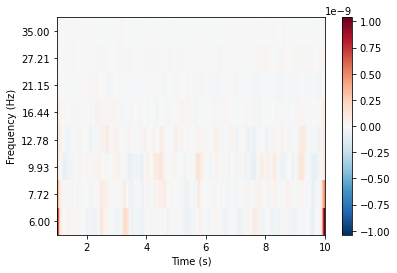

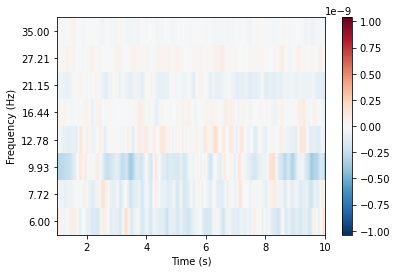

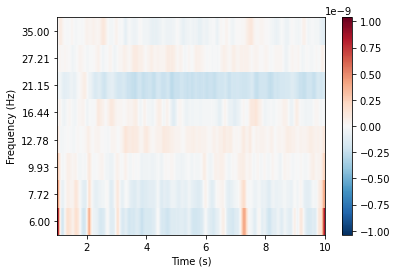

[<Figure size 432x288 with 2 Axes>,
 <Figure size 432x288 with 2 Axes>,
 <Figure size 432x288 with 2 Axes>,
 <Figure size 432x288 with 2 Axes>]

In [244]:
from mne.time_frequency import tfr_morlet

epochs_good = epochs['good'].copy().crop(tmin=1, tmax=10)

freqs = np.logspace(*np.log10([6, 35]), num=8)
n_cycles = freqs / 2.  # different number of cycle per frequency
power, itc = tfr_morlet(epochs_good, freqs=freqs, n_cycles=n_cycles, use_fft=True,
                        return_itc=True, decim=3, n_jobs=1)

power.plot(baseline=(1.5,2))

No baseline correction applied


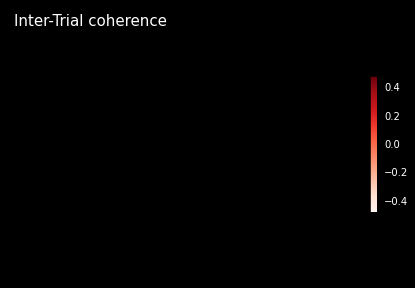

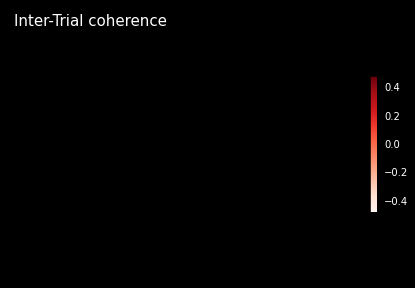

In [245]:
itc.plot_topo(title='Inter-Trial coherence', cmap='Reds')

Not setting metadata
Not setting metadata
7 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped


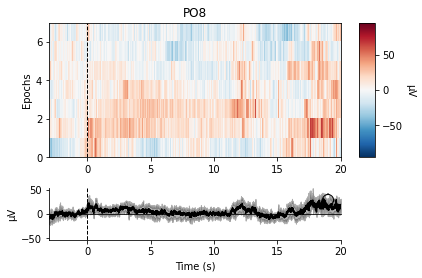

[<Figure size 432x288 with 4 Axes>]

In [247]:
epochs_clean['left/good'].plot_image(picks=['PO8'])

Not setting metadata
Not setting metadata
7 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped


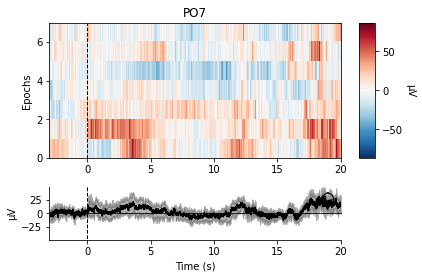

[<Figure size 432x288 with 4 Axes>]

In [248]:
epochs_clean['left/good'].plot_image(picks=['PO7'])

Not setting metadata
Not setting metadata
4 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped


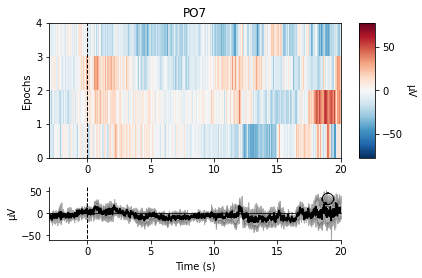

[<Figure size 432x288 with 4 Axes>]

In [249]:
epochs_clean['right/good'].plot_image(picks=['PO7'])

Not setting metadata
Not setting metadata
4 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped


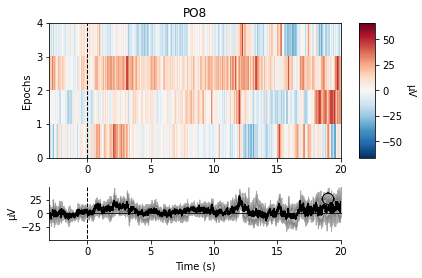

[<Figure size 432x288 with 4 Axes>]

In [250]:
epochs_clean['right/good'].plot_image(picks=['PO8'])

In [251]:
epochs_clean

Number of events,34
Events,1/classicmod/bad: 31/classicmod/good: 11/left/bad: 21/left/good: 21/right/bad: 01/right/good: 22/classicmod/bad: 02/classicmod/good: 22/left/bad: 32/left/good: 22/right/bad: 12/right/good: 13/classicmod/bad: 13/classicmod/good: 33/left/bad: 43/left/good: 33/right/bad: 33/right/good: 1
Time range,-3.000 – 20.000 sec
Baseline,-1.000 – -0.600 sec


combining channels using "gfp"
combining channels using "gfp"


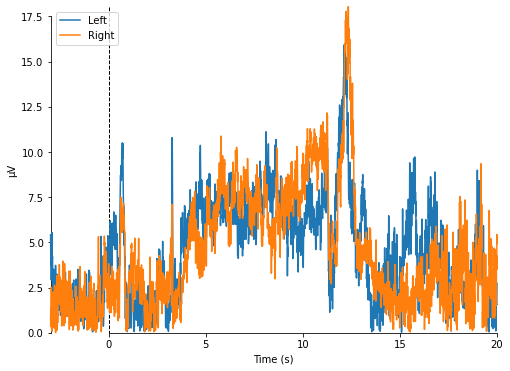

[<Figure size 576x432 with 1 Axes>]

In [258]:
mne.viz.plot_compare_evokeds({'Left':epochs['left'].pick_channels(['PO7', 'PO8']).average(), 'Right':epochs['right'].pick_channels(['PO7', 'PO8']).average()})


Not setting metadata
Not setting metadata
20 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped


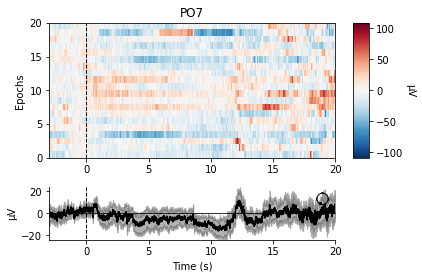

[<Figure size 432x288 with 4 Axes>]

In [259]:
epochs['right/good'].plot_image(picks=['PO7'])

Not setting metadata
Not setting metadata
31 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped


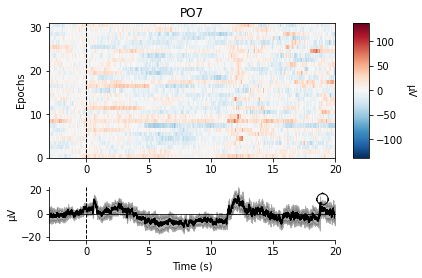

[<Figure size 432x288 with 4 Axes>]

In [260]:
epochs['bad'].plot_image(picks=['PO7'])

Not setting metadata
Not setting metadata
15 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped


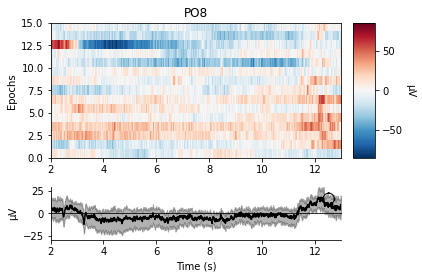

[<Figure size 432x288 with 4 Axes>]

In [263]:
epochs['left/good'].crop(tmin=2, tmax=13).plot_image(picks=['PO8'])


Embedding ERP EEG data in 2D Euclidean space with Laplacian Eigenmaps
Spectral embedding via Laplacian Eigenmaps of a set of ERP data.



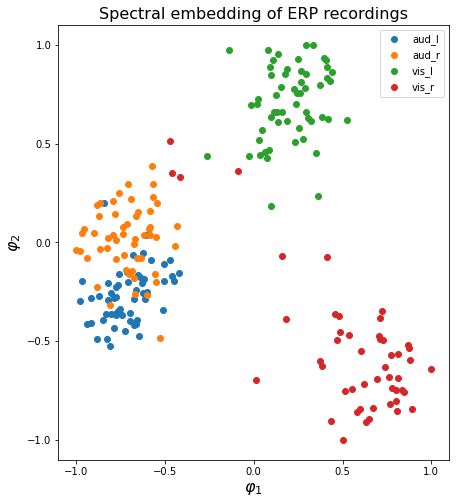

In [266]:
"""
=====================================================================
Embedding ERP EEG data in 2D Euclidean space with Laplacian Eigenmaps
=====================================================================
Spectral embedding via Laplacian Eigenmaps of a set of ERP data.
"""
# Authors: Pedro Rodrigues <pedro.rodrigues01@gmail.com>
#
# License: BSD (3-clause)

# %%
from pyriemann.estimation import XdawnCovariances
from pyriemann.embedding import Embedding

import mne
from mne import io
from mne.datasets import sample

from sklearn.model_selection import train_test_split

from matplotlib import pyplot as plt

print(__doc__)

data_path = sample.data_path()

# %%
###############################################################################
# Set parameters and read data
raw_fname = data_path + '/MEG/sample/sample_audvis_filt-0-40_raw.fif'
event_fname = data_path + '/MEG/sample/sample_audvis_filt-0-40_raw-eve.fif'
tmin, tmax = -0., 1
event_id = dict(aud_l=1, aud_r=2, vis_l=3, vis_r=4)

# Setup for reading the raw data
raw = io.Raw(raw_fname, preload=True, verbose=False)
raw.filter(2, None, method='iir')  # replace baselining with high-pass
events = mne.read_events(event_fname)

raw.info['bads'] = ['MEG 2443']  # set bad channels
picks = mne.pick_types(raw.info, meg=True, eeg=False, stim=False, eog=False,
                       exclude='bads')

# Read epochs
epochs = mne.Epochs(raw, events, event_id, tmin, tmax, proj=False,
                    picks=picks, baseline=None, preload=True, verbose=False)

X = epochs.get_data()
y = epochs.events[:, -1]

# %%
###############################################################################
# Embedding the Xdawn covariance matrices with Laplacian Eigenmaps

nfilter = 4
xdwn = XdawnCovariances(estimator='scm', nfilter=nfilter)
split = train_test_split(X, y, train_size=0.25, random_state=42)
Xtrain, Xtest, ytrain, ytest = split
covs = xdwn.fit(Xtrain, ytrain).transform(Xtest)

lapl = Embedding(metric='riemann', n_components=2)
embd = lapl.fit_transform(covs)

# %%
###############################################################################
# Plot the three first components of the embedded points

fig, ax = plt.subplots(figsize=(7, 8), facecolor='white')

for cond, label in event_id.items():
    idx = (ytest == label)
    ax.scatter(embd[idx, 0], embd[idx, 1], s=36, label=cond)

ax.set_xlabel(r'$\varphi_1$', fontsize=16)
ax.set_ylabel(r'$\varphi_2$', fontsize=16)
ax.set_title('Spectral embedding of ERP recordings', fontsize=16)
ax.set_xticks([-1.0, -0.5, 0.0, +0.5, 1.0])
ax.set_yticks([-1.0, -0.5, 0.0, +0.5, 1.0])
ax.grid(False)
ax.legend()
plt.show()
# %%


In [281]:
"""
=====================================================================
Embedding ERP EEG data in 2D Euclidean space with Laplacian Eigenmaps
=====================================================================
Spectral embedding via Laplacian Eigenmaps of a set of ERP data.
"""
# Authors: Pedro Rodrigues <pedro.rodrigues01@gmail.com>
#
# License: BSD (3-clause)

# %%
from pyriemann.estimation import XdawnCovariances
from pyriemann.embedding import Embedding

import mne
from mne import io
from mne.datasets import sample

from sklearn.model_selection import train_test_split

from matplotlib import pyplot as plt

# %%
###############################################################################
# Embedding the Xdawn covariance matrices with Laplacian Eigenmaps

nfilter = 3
xdwn = XdawnCovariances(estimator='scm', nfilter=nfilter)
split = train_test_split(X, y, train_size=0.25, random_state=42)
Xtrain, Xtest, ytrain, ytest = split
covs = xdwn.fit(Xtrain, ytrain).transform(Xtest)

lapl = Embedding(metric='riemann', n_components=2)
embd = lapl.fit_transform(covs)

# %%
###############################################################################
# Plot the three first components of the embedded points

fig, ax = plt.subplots(figsize=(7, 8), facecolor='white')

for cond, label in event_id.items():
    idx = (ytest == label)
    ax.scatter(embd[idx, 0], embd[idx, 1], s=36, label=cond)

ax.set_xlabel(r'$\varphi_1$', fontsize=16)
ax.set_ylabel(r'$\varphi_2$', fontsize=16)
ax.set_title('Spectral embedding of ERP recordings', fontsize=16)
ax.set_xticks([-1.0, -0.5, 0.0, +0.5, 1.0])
ax.set_yticks([-1.0, -0.5, 0.0, +0.5, 1.0])
ax.grid(False)
ax.legend()
plt.show()
# %%


LinAlgError: The leading minor of order 11 of B is not positive definite. The factorization of B could not be completed and no eigenvalues or eigenvectors were computed.

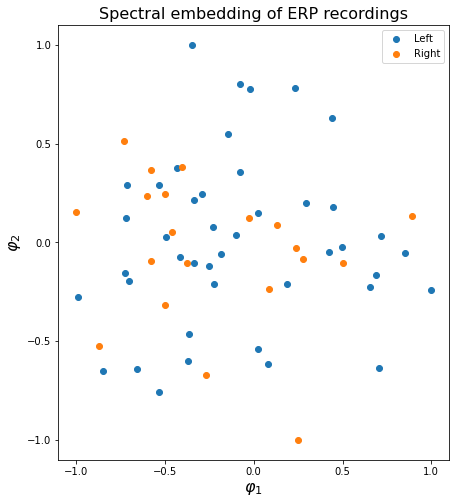

In [322]:
# %%
###############################################################################
# Embedding the Xdawn covariance matrices with Laplacian Eigenmaps

nfilter = 3
xdwn = XdawnCovariances(estimator='scm', nfilter=nfilter)
split = train_test_split(X, y, train_size=0.25, random_state=42)
Xtrain, Xtest, ytrain, ytest = split
covs = xdwn.fit(Xtrain, ytrain).transform(Xtest)

lapl = Embedding(metric='riemann', n_components=2)
embd = lapl.fit_transform(covs)

# %%
###############################################################################
# Plot the three first components of the embedded points

classes = {'Left':0, 'Right':1}

fig, ax = plt.subplots(figsize=(7, 8), facecolor='white')

for cond, label in classes.items():
    idx = (ytest == label)
    ax.scatter(embd[idx, 0], embd[idx, 1], s=36, label=cond)

ax.set_xlabel(r'$\varphi_1$', fontsize=16)
ax.set_ylabel(r'$\varphi_2$', fontsize=16)
ax.set_title('Spectral embedding of ERP recordings', fontsize=16)
ax.set_xticks([-1.0, -0.5, 0.0, +0.5, 1.0])
ax.set_yticks([-1.0, -0.5, 0.0, +0.5, 1.0])
ax.grid(False)
ax.legend()
plt.show()
# %%

In [304]:
for cond, label in classes.items():
    print(f'Cond: {cond}, Label: {label}')

Cond: Left, Label: 0
Cond: Right, Label: 1


In [311]:
ytest = np.array(ytest)

In [275]:
epochs_lf.times.shape

(11501,)

In [276]:
# %%
from pyriemann.estimation import XdawnCovariances
from pyriemann.embedding import Embedding

import mne
from mne import io
from mne.datasets import sample

from sklearn.model_selection import train_test_split

from matplotlib import pyplot as plt

print(__doc__)

data_path = sample.data_path()

# %%
###############################################################################
# Set parameters and read data
raw_fname = data_path + '/MEG/sample/sample_audvis_filt-0-40_raw.fif'
event_fname = data_path + '/MEG/sample/sample_audvis_filt-0-40_raw-eve.fif'
tmin, tmax = -0., 1
event_id = dict(aud_l=1, aud_r=2, vis_l=3, vis_r=4)

# Setup for reading the raw data
raw = io.Raw(raw_fname, preload=True, verbose=False)
raw.filter(2, None, method='iir')  # replace baselining with high-pass
events = mne.read_events(event_fname)

raw.info['bads'] = ['MEG 2443']  # set bad channels
picks = mne.pick_types(raw.info, meg=True, eeg=False, stim=False, eog=False,
                       exclude='bads')

# Read epochs
epochs = mne.Epochs(raw, events, event_id, tmin, tmax, proj=False,
                    picks=picks, baseline=None, preload=True, verbose=False)

X = epochs.get_data()
y = epochs.events[:, -1]

# %%
###############################################################################
# Embedding the Xdawn covariance matrices with Laplacian Eigenmaps

nfilter = 4
xdwn = XdawnCovariances(estimator='scm', nfilter=nfilter)
split = train_test_split(X, y, train_size=0.25, random_state=42)
Xtrain, Xtest, ytrain, ytest = split
covs = xdwn.fit(Xtrain, ytrain).transform(Xtest)

lapl = Embedding(metric='riemann', n_components=2)
embd = lapl.fit_transform(covs)

covs.shape


Embedding ERP EEG data in 2D Euclidean space with Laplacian Eigenmaps
Spectral embedding via Laplacian Eigenmaps of a set of ERP data.



array([[[ 5.63522785e-27,  1.71496660e-42, -2.13903107e-42, ...,
          8.91968664e-28, -1.14948063e-28,  2.99033799e-28],
        [ 1.71496660e-42,  1.58890448e-27,  1.73219050e-42, ...,
          2.69523005e-28,  2.36184896e-29, -2.70901918e-29],
        [-2.13903107e-42,  1.73219050e-42,  1.85017520e-27, ...,
         -6.57674770e-28, -7.98399011e-28,  1.72034191e-28],
        ...,
        [ 8.91968664e-28,  2.69523005e-28, -6.57674770e-28, ...,
          3.20809469e-27,  6.34867987e-28, -2.08560022e-28],
        [-1.14948063e-28,  2.36184896e-29, -7.98399011e-28, ...,
          6.34867987e-28,  2.65747173e-27,  1.71105856e-29],
        [ 2.99033799e-28, -2.70901918e-29,  1.72034191e-28, ...,
         -2.08560022e-28,  1.71105856e-29,  2.11273120e-27]],

       [[ 5.63522785e-27,  1.71496660e-42, -2.13903107e-42, ...,
         -1.89401623e-28,  1.08997701e-27, -1.32631893e-28],
        [ 1.71496660e-42,  1.58890448e-27,  1.73219050e-42, ...,
         -4.66809309e-28, -7.45250197e

In [277]:
covs.shape

(216, 32, 32)

In [283]:
#==================================================================
# Main Loop - Loading All Files & Extract CDAs.
#==================================================================
directory_path = '/Users/nick/Documents/PhD/CAE - InLook/NeuroTracker - Sub/'

filepath = directory_path + 'F12F2.bdf'
#for filepath in glob.iglob(directory_path + '*.bdf'):
filename = filepath[filepath.rfind('/')+1:]
print('Processing: ' + filename + '...')

# 1. -- Load File --
raw = read_raw_bdf(filepath, preload=True)

# 2. -- General Preprocess --
# Keep only EEG channels and reference
raw = raw.drop_channels(ch_names=['EXG1','EXG2','EXG3','EXG6','EXG7', 'EXG8'])
raw = raw.set_eeg_reference(ref_channels=['EXG4', 'EXG5'])
raw = raw.set_channel_types({'EXG4': 'misc', 'EXG5': 'misc'})

# Set Electrodes Locations
montage = mne.channels.make_standard_montage('biosemi64')
raw.set_montage(montage)
#raw = mne.set_bipolar_reference(raw, anode=chan_right, cathode=chan_left)

# Resample
preproc = raw.resample(500)

# Filter
preproc = preproc.filter(.1, 50., fir_design='firwin', skip_by_annotation='edge')

# ------------------------
# 3. -- Epochs --
# ------------------------
events = find_events(preproc)

#preproc = preproc.pick_channels(['P8-P7', 'PO8-PO7', 'PO4-PO3', 'AF4-AF3'])
#preproc = preproc.pick_channels(['AF4-AF3'])

# ---------- Debug Logs ----------
frequency = collections.Counter(events[:,2])
events_frequency = dict(frequency)
print('Max Events in File...')
print("---------------------------")
for e in set(events[:,2]):
    print("{}: \t\t{}".format(e, frequency[e]))
print("---------------------------")
# ---------- Debug Logs ----------

df_behav = pd.read_csv(directory_path + filename[:filename.rfind('.')] + '.csv', sep=',')

new_events = []
nb_trials = 0
total_skipped = 0
for e in events:
    cur_cond = None
    cur_side = None
    cur_perf = None
    if e[2] == 2: # Find Start of Trial
        cur_cond = str(df_behav['NbTargets'].values[nb_trials]).lower()
        cur_side = str(df_behav['Mode'].values[nb_trials]).lower()
        cur_perf = 'good' if (int(df_behav['NbTargets'].values[nb_trials]) == int(df_behav['Results'].values[nb_trials])) else 'bad'
        if cur_cond is not None and cur_side is not None and cur_perf is not None:
            #temp_trigger = int(custom_trigger[cur_cond]) + int(custom_trigger[cur_side]) + int (custom_trigger[cur_perf])
            temp_event = [e[0], e[1], event_id['{}/{}/{}'.format(cur_cond, cur_side, cur_perf)]]
            new_events.append(temp_event) # Make a new list of events with new custom triggers.
        else:
            total_skipped = total_skipped + 1
            print('Skipping this event {}: No Cond or Side or Perf'.format(e))

        nb_trials = nb_trials + 1

        # Check Synch!
        if (nb_trials + 1) % 10 == 0:
            print('Check Synch!')

print("A total of {} trials were added and {} were skipped.".format(nb_trials, total_skipped))

epochs = Epochs(preproc, new_events, event_id=event_id, tmin=epoch_tmin, tmax=epoch_length, baseline=baseline_corr, preload=True, event_repeated='merge', on_missing='warn')
#epochs = get_epochs(preproc, specific_events, epoch_length, epoch_tmin, baseline_corr)

epochs_lf = epochs[['left','right']] # To avoid the Classic Mod

#x = epochs_lf['left'].average().plot()
#x = epochs_lf['right'].average().plot()

X = epochs_lf.get_data()
y = [0 if e[0] in epochs_lf['left'].events[:,0] else 1 for i,e in enumerate(epochs_lf.events)]

Processing: F12F2.bdf...
Extracting EDF parameters from /Users/nick/Documents/PhD/CAE - InLook/NeuroTracker - Sub/F12F2.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 5986303  =      0.000 ...  2923.000 secs...
EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Trigger channel has a non-zero initial value of 65536 (consider using initial_event=True to detect this event)
Removing orphaned offset at the beginning of the file.
516 events found
Event IDs: [ 1  2  4  8 16 32]
Trigger channel has a non-zero initial value of 65536 (consider using initial_event=True to detect this event)
Removing orphaned offset at the beginning of the file.
516 events found
Event IDs: [ 1  2  4  8 16 32]
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain des

/var/folders/gn/5c249d_15xb7y6sdl7n8cn9m0000gn/T/ipykernel_9709/3586431614.py:78: RuntimeWarning: No matching events found for 1/right/bad (event id 112)
  epochs = Epochs(preproc, new_events, event_id=event_id, tmin=epoch_tmin, tmax=epoch_length, baseline=baseline_corr, preload=True, event_repeated='merge', on_missing='warn')


0 bad epochs dropped


In [348]:
epochs_lf = epochs[['left','right']] # To avoid the Classic Mod

#x = epochs_lf['left'].average().plot()
#x = epochs_lf['right'].average().plot()

#X = epochs_lf.copy().crop(tmin=10, tmax=13).pick_types(eeg=True).get_data()
X = epochs_lf.copy().crop(tmin=11, tmax=15).pick_channels(chan_right + chan_left).get_data()
y = np.array([0 if e[0] in epochs_lf['left'].events[:,0] else 1 for i,e in enumerate(epochs_lf.events)])

idx = np.arange(X.shape[0])
np.random.shuffle(idx)
X = X[idx]
y = y[idx]

y

array([0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1,
       0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0,
       1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1])

Classif Acc: 0.816667 


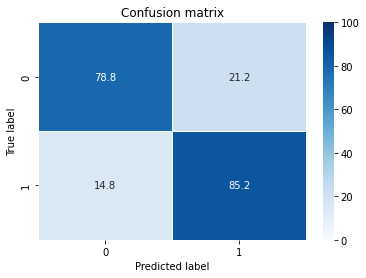

In [349]:
from sklearn.model_selection import KFold
from pyriemann.tangentspace import TangentSpace
from pyriemann.utils.viz import plot_confusion_matrix

n_components = 2

cv = KFold(n_splits=5, shuffle=True, random_state=42)

clf = make_pipeline(XdawnCovariances(n_components),
                    TangentSpace(metric='riemann'),
                    LogisticRegression())

preds = np.zeros(len(y))

for train_idx, test_idx in cv.split(X):
    y_train, y_test = y[train_idx], y[test_idx]

    clf.fit(X[train_idx], y_train)
    preds[test_idx] = clf.predict(X[test_idx])

acc = np.mean(preds == y)
print("Classif Acc: %f " % (acc))

names = ['0', '1']
plot_confusion_matrix(preds, y, names)
plt.show()

In [356]:
epochs_lf = epochs[['good','bad']] # To avoid the Classic Mod

#x = epochs_lf['left'].average().plot()
#x = epochs_lf['right'].average().plot()

#X = epochs_lf.copy().crop(tmin=10, tmax=13).pick_types(eeg=True).get_data()
X = epochs_lf.copy().crop(tmin=2, tmax=14).pick_channels(chan_right + chan_left).get_data()
y = np.array([0 if e[0] in epochs_lf['good'].events[:,0] else 1 for i,e in enumerate(epochs_lf.events)])

idx = np.arange(X.shape[0])
np.random.shuffle(idx)
X = X[idx]
y = y[idx]

y

array([1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0,
       1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0])

Classif Acc: 0.619048 


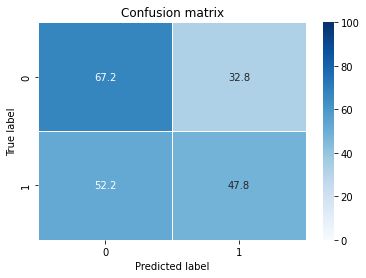

In [357]:
from sklearn.model_selection import KFold
from pyriemann.tangentspace import TangentSpace
from pyriemann.utils.viz import plot_confusion_matrix

n_components = 2

cv = KFold(n_splits=5, shuffle=True, random_state=42)

clf = make_pipeline(XdawnCovariances(n_components),
                    TangentSpace(metric='riemann'),
                    LogisticRegression())

preds = np.zeros(len(y))

for train_idx, test_idx in cv.split(X):
    y_train, y_test = y[train_idx], y[test_idx]

    clf.fit(X[train_idx], y_train)
    preds[test_idx] = clf.predict(X[test_idx])

acc = np.mean(preds == y)
print("Classif Acc: %f " % (acc))

names = ['0', '1']
plot_confusion_matrix(preds, y, names)
plt.show()